### Mount Google Drive (Works only on Google Colab)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Import Packages



In [0]:
import os
import numpy as np
import pandas as pd

from zipfile import ZipFile
from PIL import Image
from tqdm.autonotebook import tqdm
from IPython.display import display
from IPython.display import Image as Dimage

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


# Define Paths

Define paths of all the required directories

In [0]:
# Root path of the dataset
ROOT_DATA_DIR = '/content/gdrive/My Drive/modest_museum_dataset.zip'

# Data Visualization

Let's visualize some of the foreground and background images

In [0]:
def make_grid(images_list, height=140, margin=8, aspect_ratio=False):
    """Combine Images to form a grid.

    Args:
        images (list): List of PIL images to display in grid.
        height (int): Height to which the image will be resized.
        margin (int): Amount of padding between the images in grid.
        aspect_ratio (bool, optional): Create grid while maintaining
            the aspect ratio of the images. (default: False)
    
    Returns:
        Image grid.
    """

    # Create grid template
    widths = []
    if aspect_ratio:
        for image in images_list:
            # Find width according to aspect ratio
            h_percent = height / image.size[1]
            widths.append(int(image.size[0] * h_percent))
    else:
        widths = [height] * len(images_list)
    
    start = 0
    background = Image.new(
        'RGBA', (sum(widths) + (len(images_list) - 1) * margin, height)
    )
    
    # Add images to grid
    for idx, image in enumerate(images_list):
        image = image.resize((widths[idx], height))
        offset = (start, 0)
        start += (widths[idx] + margin)
        background.paste(image, offset)
    
    return background

# Data Statistics

Let's calculate mean, standard deviation and total number of images for each type of image category.

## Mean

Mean is calculated using the formula

<center>
  <img src="https://www.gstatic.com/education/formulas/images_long_sheet/en/mean.svg" height="50">
</center>

where, `sum of the terms` represents a pixel value and `number of terms` represents the total number of pixels across all the images.

## Standard Deviation

Standard Deviation is calculated using the formula

<center>
  <img src="https://www.gstatic.com/education/formulas/images_long_sheet/en/population_standard_deviation.svg" height="50">
</center>

where, `x` represents a pixel value, `u` represents the mean calculated above and `N` represents the total number of pixels across all the images.

In [0]:
def statistics(filename, channel_num, filetype):
    """Calculates data statistics

    Args:
        path (str): Path of the directory for which statistics is to be calculated

    Returns:
        Mean, standard deviation, number of images
    """

    counter = 0
    mean = []
    std = []
    images = [] # store PIL instance of the image

    pixel_num = 0 # store all pixel number in the dataset
    channel_sum = np.zeros(channel_num) # store channel-wise sum
    channel_sum_squared = np.zeros(channel_num) # store squared channel-wise sum

    with ZipFile(filename) as archive:
        img_list = [
            x for x in archive.infolist()
            if x.filename.split('/')[1] == filetype and x.filename.split('/')[2].endswith('.jpeg')
        ]
        for entry in tqdm(img_list):
            with archive.open(entry) as file:
                img = Image.open(file)
                if len(images) < 5:
                    images.append(img)
                im = np.array(img)
                im = im / 255.0
                pixel_num += (im.size / channel_num)
                channel_sum += np.sum(im, axis=(0, 1))
                channel_sum_squared += np.sum(np.square(im), axis=(0, 1))
                counter += 1
        bgr_mean = channel_sum / pixel_num
        bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))
        
        # change the format from bgr to rgb
        mean = [round(x, 5) for x in list(bgr_mean)[::-1]]
        std = [round(x, 5) for x in list(bgr_std)[::-1]]

    return mean, std, counter, im.shape, images

# Statistics for Background images

In [0]:
# Background
print('Calculating statistics for Backgrounds...')
bg_mean, bg_std, bg_counter, bg_dim, bg_images = statistics(ROOT_DATA_DIR, 3, 'bg')

Calculating statistics for Backgrounds...


Background Images:


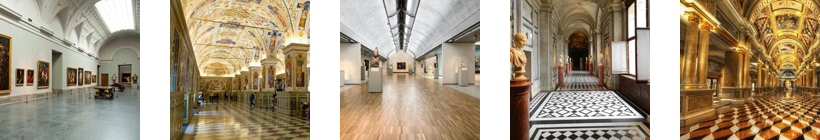

In [0]:
# Display
print('Background Images:')
make_grid(bg_images, margin=30)

In [0]:
print('Data Statistics for Background images')

stats = {
    'Statistics': ['Mean', 'Standard deviation', 'Number of images', 'Dimension'],
    'Data': [bg_mean, bg_std, bg_counter, bg_dim]
}

data = pd.DataFrame(stats)
data

Data Statistics for Background images


,Statistics,Data
0,Mean,"[0.40086, 0.46599, 0.53281]"
1,Standard deviation,"[0.25451, 0.24249, 0.23615]"
2,Number of images,100
3,Dimension,"(224, 224, 3)"


# Statistics for Background-Foreground images

In [0]:
# Background-Foreground
print('Calculating statistics for Background-Foreground Images...')
bg_fg_mean, bg_fg_std, bg_fg_counter, bg_fg_dim, bg_fg_image = statistics(ROOT_DATA_DIR, 3, 'bg_fg')

Calculating statistics for Background-Foreground Images...


Background-Foreground Images:


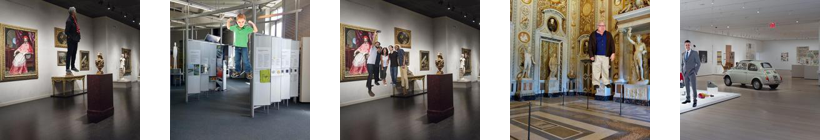

In [0]:
# Display
print('Background-Foreground Images:')
make_grid(bg_fg_image, margin=30)

In [0]:
print('Data Statistics for Background-Foreground images')

stats = {
    'Statistics': ['Mean', 'Standard deviation', 'Number of images', 'Dimension'],
    'Data': [bg_fg_mean, bg_fg_std, bg_fg_counter, bg_fg_dim]
    }

data = pd.DataFrame(stats)
data

Data Statistics for Background-Foreground images


,Statistics,Data
0,Mean,"[0.41221, 0.47368, 0.53431]"
1,Standard deviation,"[0.25699, 0.24577, 0.24217]"
2,Number of images,400000
3,Dimension,"(224, 224, 3)"


# Statistics for Background-Foreground Masks

In [0]:
#Foreground-Background Masks
print('Calculating statistics for Foreground-Background Masks...')
bg_fg_mask_mean, bg_fg_mask_std, bg_fg_mask_counter, bg_fg_mask_dim, bg_fg_mask_images = statistics(ROOT_DATA_DIR, 1, 'bg_fg_mask')

Calculating statistics for Foreground-Background Masks...


Background-Foreground Masks:


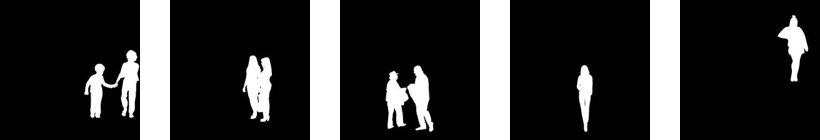

In [0]:
# Display
print('Background-Foreground Masks:')
make_grid(bg_fg_mask_images, margin=30, aspect_ratio=True)

In [0]:
print('Data Statistics for Background-Foreground Masks images')

stats = {
    'Statistics': ['Mean', 'Standard deviation', 'Number of images', 'Dimension'],
    'Data': [bg_fg_mask_mean, bg_fg_mask_std, bg_fg_mask_counter, bg_fg_mask_dim]
    }

data = pd.DataFrame(stats)
data

Data Statistics for Background-Foreground Masks images


,Statistics,Data
0,Mean,[0.05207]
1,Standard deviation,[0.21686]
2,Number of images,400000
3,Dimension,"(224, 224)"


# Statistics for Background-Foreground Depth Maps

In [0]:
#Foreground-Background Depth Map
print('Calculating statistics for Foreground-Background Depth Map...')
depth_mean, depth_std, depth_counter, depth_dim, depth_images = statistics(ROOT_DATA_DIR, 1, 'bg_fg_depth_map')

Calculating statistics for Foreground-Background Depth Map...


Background-Foreground Depth Maps:


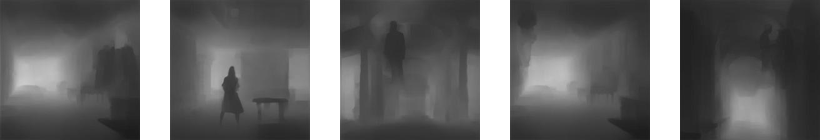

In [0]:
# Display
print('Background-Foreground Depth Maps:')
make_grid(depth_images, margin=30)

In [0]:
print('Data Statistics for Background-Foreground Depth Map images')

stats = {
    'Statistics': ['Mean', 'Standard deviation', 'Number of images', 'Dimension'],
    'Data': [depth_mean, depth_std, depth_counter, depth_dim]
    }

data = pd.DataFrame(stats)
data

Data Statistics for Background-Foreground Depth Map images


,Statistics,Data
0,Mean,[0.2981]
1,Standard deviation,[0.11561]
2,Number of images,400000
3,Dimension,"(224, 224)"
